# Setting up Fisher matrix calculation

In [2]:
import classy as Class
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from datetime import datetime
from IPython.display import display, clear_output

######################################################
#  Setting up plots
######################################################

%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
plt.rcParams["figure.figsize"] = [8.0,6.0]
plt.rcParams['text.usetex']=False

fsize=14

######################################################
#  Setting fiducial parameters
#  Planck18 TT,TE,EE+lowE+lensing
######################################################

ln10e10As = 3.044

planck_baseline_params = {
    "omega_b": 0.02237,
    "omega_cdm": 0.1200,
    "n_s": 0.9649,
    "tau_reio": 0.0544,
    "ln10^{10}A_s": ln10e10As,
    "H0": 67.36
}

planck_baseline_sigma = {
    "omega_b": 0.00015,
    "omega_cdm": 0.0012,
    "n_s": 0.0042,
    "tau_reio": 0.0073,
    "ln10^{10}A_s": 0.014,
    "H0": 0.54
}

######################################################
#  Configuring the run
######################################################


common_settings = {'output' : 'tCl,pCl,lCl',
                   'thermodynamics_verbose': 0,
                   'input_verbose': 0,
                   'lensing': 'yes',
                   'xe_pert_type': 'none'
                  }

#LCDM parameters
for name, value in planck_baseline_params.items():
    common_settings.update({name: value})

pr_cover_tau = 0.004
precision_settings = {"start_sources_at_tau_c_over_tau_h": pr_cover_tau}

M = Class.Class()
M.set(common_settings)
M.set(precision_settings)
print(Class.__file__)

/Users/gabe/.local/lib/python3.9/site-packages/classy-3.1.0-py3.9-macosx-10.9-x86_64.egg/classy.cpython-39-darwin.so


In [3]:
M.compute()

# Finding perturbation $z_{min}$ and $z_{max}$

In [4]:
from scipy.interpolate import interp1d

fiducial_thermo = M.get_thermodynamics()
Tcmb = M.T_cmb()*10**6 #cmb temp in micro kelvin
ll_max = 2500
ll = np.arange(2, ll_max+1)
muK2 = (Tcmb)**2

######################################################
# Fiducial quantities
######################################################

tt_fid = muK2*M.lensed_cl(ll_max)['tt'][2:]
te_fid = muK2*M.lensed_cl(ll_max)['te'][2:]
ee_fid = muK2*M.lensed_cl(ll_max)['ee'][2:]
xe_fid = fiducial_thermo["x_fid"]
viz_fid = fiducial_thermo["kappa' [Mpc^-1]"]*fiducial_thermo["exp(-kappa)"]

Yp_fid = M.get_current_derived_parameters(['YHe'])['YHe']
xe_max_fid = 1 + Yp_fid/2*(1-Yp_fid)

######################################################
# z_min and z_max are set by picking some 
# threshold where the visibility function equals
# a given percentage of its maximum
######################################################

ind_max = np.argmax(viz_fid)
max_viz = viz_fid[ind_max]

highz_percent_cutoff = 0.2
lowz_percent_cutoff = 0.05

test = np.where(viz_fid<highz_percent_cutoff*max_viz, 1, 0) #when true, array will be 1, 0 when false
ind_highz = np.argwhere(np.diff(test)==1)[0][0] #finds first index where we switch from true to false

test = np.where(viz_fid<lowz_percent_cutoff*max_viz, 1, 0)
ind_lowz = np.argwhere(np.diff(test)==-1)[0][0]

print("Viz function has value {0} at index {1} and redshift {2}".format(viz_fid[ind_highz], ind_highz, fiducial_thermo['z'][ind_highz]))
print("{0:.2f}*viz_max = {1}".format(highz_percent_cutoff, highz_percent_cutoff*max_viz))

print("Viz function has value {0} at index {1} and redshift {2}".format(viz_fid[ind_lowz], ind_lowz, fiducial_thermo['z'][ind_lowz]))
print("{0:.2f}*viz_max = {1}".format(lowz_percent_cutoff, lowz_percent_cutoff*max_viz))

######################################################
# Setting string of control point pivots
# First varied pivot will be at redshift
# found above
######################################################

num_control_points = 4
free_pivots = np.linspace(start=np.floor(fiducial_thermo['z'][ind_lowz]), stop=np.floor(fiducial_thermo['z'][ind_highz]), num=num_control_points)
dz_pivot = np.diff(free_pivots)[0]
zmin_pert = free_pivots[0] - dz_pivot
zmax_pert = free_pivots[-1] + dz_pivot

pivots = np.insert(free_pivots, 0, zmin_pert)
pivots = np.append(pivots, zmax_pert)

str_pivots = ["{:.4f}".format(p) for p in pivots]
str_pivots = ",".join(str_pivots)
print("Pivot redshifts are at {}".format(str_pivots))

Viz function has value 0.004273284278013431 at index 5687 and redshift 1221.115
0.20*viz_max = 0.004248102027881591
Viz function has value 0.0010619822969247402 at index 4882 and redshift 820.6275
0.05*viz_max = 0.0010620255069703978
Pivot redshifts are at 686.3333,820.0000,953.6667,1087.3333,1221.0000,1354.6667


# Setting up Fisher calculation


In [5]:
sys.path.insert(0, '/Users/gabe/projects/recombination/src')
from RecTools import *

#######################################################
# Fisher parameters
######################################################

# reproducing here the fiducial cosmology for clarity

ln10e10As = 3.044

planck_baseline_params = {
    "omega_b": 0.02237,
    "omega_cdm": 0.1200,
    "n_s": 0.9649,
    "tau_reio": 0.0544,
    "ln10^{10}A_s": ln10e10As,
    #"1e9*A_s*exp(-2tau)": 1.883,
    "H0": 67.36
}

noise_parameters = {'beam_FWHM_143_arcmin' : 7.3,
                        'beam_FWHM_217_arcmin' : 4.90,
                        'weight_inv_T_143' : 0.36e-4,
                        'weight_inv_P_143' : 1.61e-4,
                        'weight_inv_T_217' : 0.78e-4,
                        'weight_inv_P_217' : 3.25e-4,
                        'fsky' : 0.8,
                        'use_143' : True,
                        'use_217' : True
                        }  

priors = {'tau_reio': 0.0073}

#for now just do a 'standard' fisher calculation
recombination_params = {"zmin_pert": zmin_pert,
                        "zmax_pert": zmax_pert,
                        "ll_max": 2500,
                        "thermodynamics_verbose": 0,
                        "xe_pert_type": 'control',
                        "noise_params": noise_parameters,
                        "save_output": False,
                        "ll_min_pol": 10,
                        "priors": priors,
                        "xe_control_pivots": str_pivots
                        }

#######################################################
# Fisher calculation
######################################################

In [6]:
calc = FisherCalculator(planck_baseline_params, recombination_params, "test")
target_params = [*planck_baseline_params.keys(), "xe_control_points"]
print(target_params)
fm = calc.compute_Fisher(target_params)
#print(list(planck_baseline_params.keys()))

['omega_b', 'omega_cdm', 'n_s', 'tau_reio', 'ln10^{10}A_s', 'H0', 'xe_control_points']
Computing Fisher matrix for variables: ['omega_b', 'omega_cdm', 'n_s', 'tau_reio', 'ln10^{10}A_s', 'H0', 'xe_control_points']
omega_b
omega_cdm
n_s
tau_reio
ln10^{10}A_s
H0
q_1
q_2
q_3
q_4
Fisher matrices calculation completed at 02/22/2023, 12:02:46


In [7]:
def param_pairs(params_to_plot):
    n=len(params_to_plot)
    param_combos = []

    for i in np.arange(n):
        for j in np.arange(n):
            if i>j:
                param_combos.append([params_to_plot[i], params_to_plot[j]])
    return param_combos


params_to_plot = ["H0", "omega_b", "omega_cdm", "logA", "n_s", "tau_reio"]
param_combos = param_pairs(params_to_plot)

In [8]:
from getdist import plots, MCSamples, loadMCSamples
import getdist

samples_to_load = ["lcdm", "mcmc7", "mcmc4"]
sample_burnin_frac = {"lcdm": 0.2, 
                    "mcmc7": 0.2,
                    "mcmc4": 0.2}

sample_dict = {}

cobaya_dir = "/Users/gabe/projects/cobaya"

for sample in samples_to_load:
    sample_path = os.path.join(cobaya_dir, sample, "chains", sample)
    s = loadMCSamples(sample_path)
    sample_dict[sample] = s

p=sample_dict["lcdm"].getParams()
sample_dict["lcdm"].addDerived(1e9*p.A_s*np.exp(-2*p.tau_reio), name='1e9_As_exp2tau', label='10^{9}A_s\exp{(-2 \\tau)}')
#print(sample_dict["lcdm"].getParams()
bestfit_dict = sample_dict["lcdm"].getParamBestFitDict()
print(sample_dict["lcdm"].getInlineLatex("1e9_As_exp2tau", limit=1))
print(bestfit_dict.keys())

10^{9}A_s\exp{(-2 \tau)} = 1.881\pm 0.011
dict_keys(['logA', 'n_s', 'theta_s_1e2', 'omega_b', 'omega_cdm', 'tau_reio', 'A_planck', 'A_s', 'H0', 'Omega_m', 'omegamh2', 'Omega_Lambda', 'YHe', 'z_reio', 'A', 'clamp', 'chi2__CMB', 'chi2__planck_2018_lowl.TT', 'chi2__planck_2018_lowl.EE', 'chi2__planck_2018_highl_plik.TTTEEE_lite', 'chi2__planck_2018_lensing.clik', 'weight', 'loglike'])


In [9]:
bestfit = {
    "omega_b": bestfit_dict["omega_b"],
    "omega_cdm": bestfit_dict["omega_cdm"],
    "n_s": bestfit_dict["n_s"],
    "tau_reio": bestfit_dict["tau_reio"],
    "ln10^{10}A_s": bestfit_dict["logA"],
    #"100*theta_s": bestfit_dict["theta_s_1e2"]
    "H0": bestfit_dict["H0"]
}

priors = {"tau_reio": 0.0073}

recombination_params = {"zmin_pert": zmin_pert,
                        "zmax_pert": zmax_pert,
                        "ll_max": 2500,
                        "thermodynamics_verbose": 0,
                        "xe_pert_type": 'control',
                        "noise_params": noise_parameters,
                        "save_output": False,
                        "ll_min_pol": 10,
                        "priors": priors,
                        "xe_control_pivots": str_pivots
                        }

calc = FisherCalculator(bestfit, recombination_params, "test")
target_params = [*bestfit.keys()]
print(target_params)
fm2 = calc.compute_Fisher(target_params)

['omega_b', 'omega_cdm', 'n_s', 'tau_reio', 'ln10^{10}A_s', 'H0']
Computing Fisher matrix for variables: ['omega_b', 'omega_cdm', 'n_s', 'tau_reio', 'ln10^{10}A_s', 'H0']
omega_b
omega_cdm
n_s
tau_reio
ln10^{10}A_s
H0
Fisher matrices calculation completed at 02/22/2023, 12:04:33


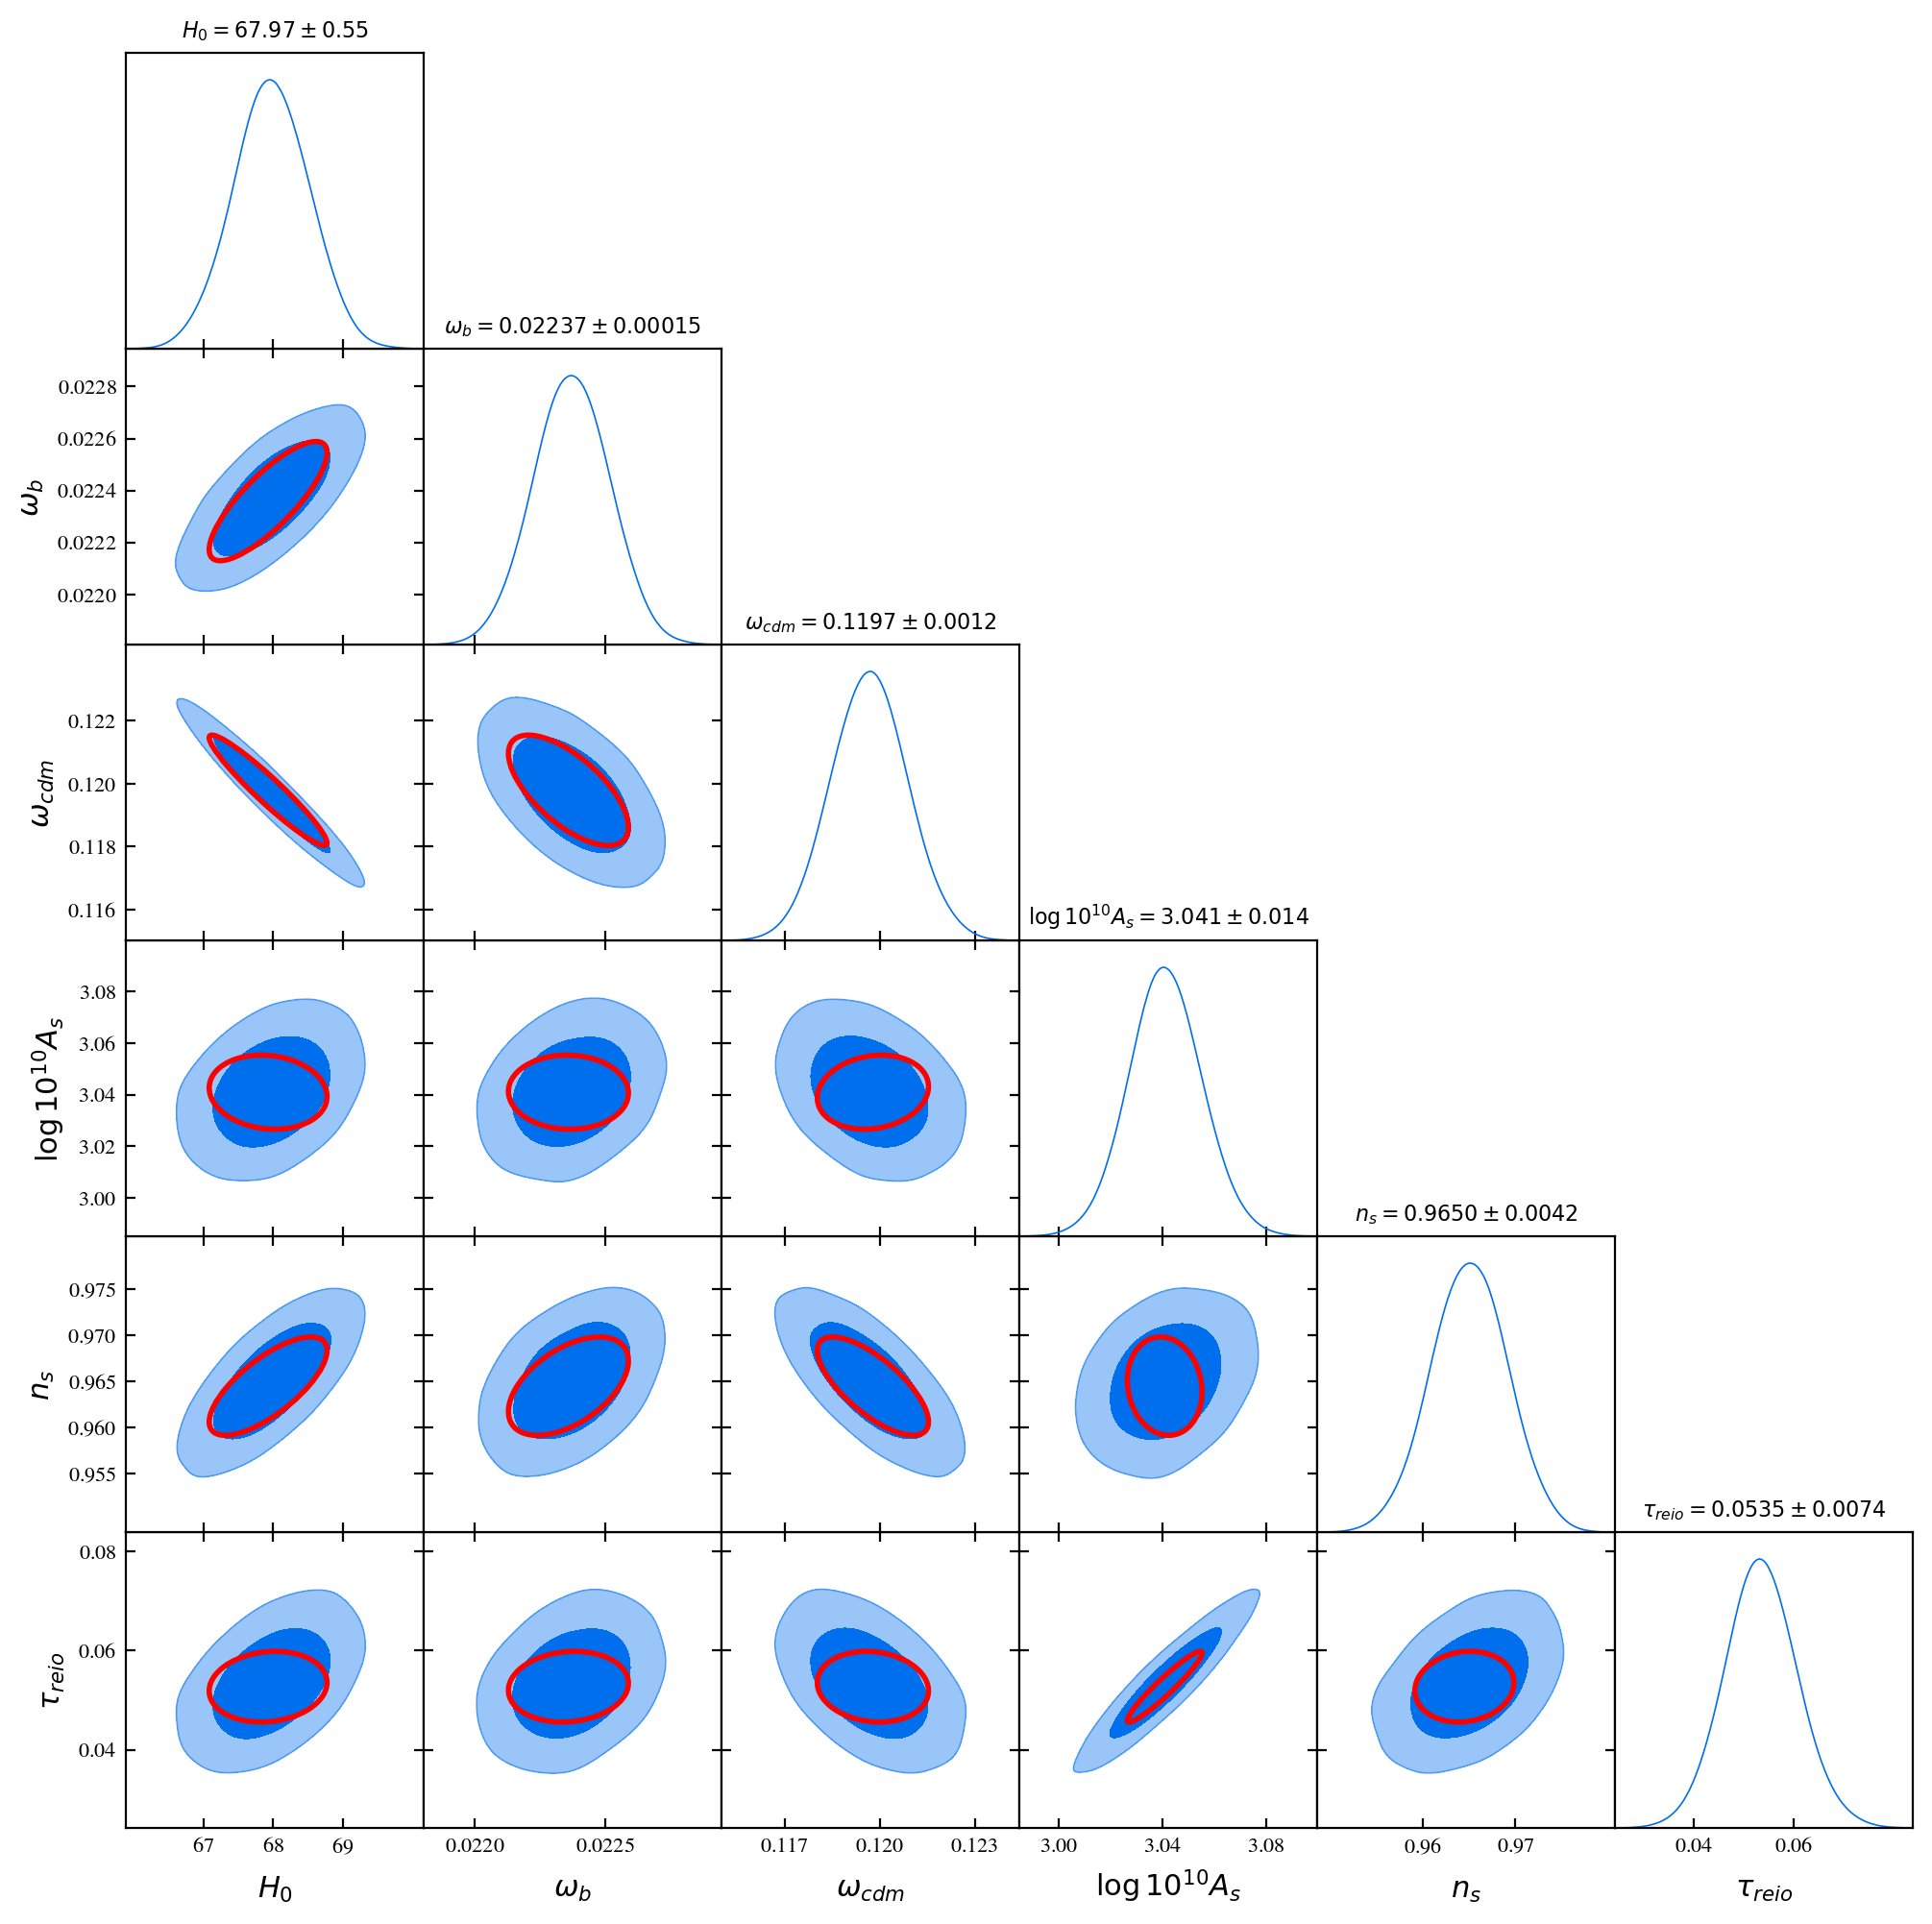

In [10]:
g = plots.get_subplot_plotter()
#params_to_plot = ["theta_s_1e2", "omega_b", "omega_cdm", "logA", "n_s", "tau_reio"]
params_to_plot = ["H0", "omega_b", "omega_cdm", "logA", "n_s", "tau_reio"]
param_combos = param_pairs(params_to_plot)
g.triangle_plot([sample_dict["lcdm"]], params_to_plot, filled=True, title_limit=1)
#print(g.subplots[0,0].text(0.5,0.5,"hi", transform=g.subplots[0,0].transAxes))
for c in param_combos:
    names = c.copy()
    ax=g.get_axes((c[1], c[0]))
    if(c[0]=="logA"):
        names[0]="ln10^{10}A_s"
    if(c[1]=="logA"):
        names[1]="ln10^{10}A_s"
    if(c[0]=="theta_s_1e2"):
        names[0]="100*theta_s"
    if(c[1]=="theta_s_1e2"):
        names[1]="100*theta_s"
    ax.add_patch(fm2.ellipse2d([names[1], names[0]]))
#g.export(fname="fisher_triangle_plot.pdf")

# Calculating step size

In [11]:
priors = {"tau_reio": 0.0073}

recombination_params = {"zmax_pert": 2000,
                        "zmin_pert": 400,
                        "ll_max": 2500,
                        "thermodynamics_verbose": 0,
                        "xe_pert_type": 'none',
                        "noise_params": noise_parameters,
                        "save_output": False,
                        "ll_min_pol": 10,
                        "priors": priors,
                        }
calc = FisherCalculator(planck_baseline_params, recombination_params, "test")
target_params = [*bestfit.keys()]
fm = calc.compute_Fisher(target_params)

Computing Fisher matrix for variables: ['omega_b', 'omega_cdm', 'n_s', 'tau_reio', 'ln10^{10}A_s', 'H0']
omega_b
omega_cdm
n_s
tau_reio
ln10^{10}A_s
H0
Fisher matrices calculation completed at 02/22/2023, 12:05:14


In [12]:
def create_parameter_values(fiducial, dp, nvals=5):
    if(nvals%2==0):
        m=nvals/2
    else:
        m=(nvals-1)/2
    return np.linspace(-m*dp, m*dp, nvals) + fiducial

fractional_mult = np.logspace(-1, np.log10(5), 10)
print(fractional_mult)

tt_derivs = {}
param = "ln10^{10}A_s"
for f in fractional_mult:
    calc.reset_boltzmann()
    dparam = f*planck_baseline_sigma[param]
    print(dparam)
    vals = create_parameter_values(planck_baseline_params[param], dparam, 5)
    tt, ee, te = calc.partial_derivative(param, vals, dparam)
    tt_derivs[f] = tt

[0.1        0.15444521 0.23853323 0.36840315 0.56898102 0.87876393
 1.35720881 2.096144   3.23739401 5.        ]
0.0014000000000000002
0.0021622329469249304
0.0033394652262626213
0.005157644098096542
0.00796573428386947
0.012302695082165742
0.019000923316164344
0.029346016011574754
0.04532351620086677
0.07000000000000002


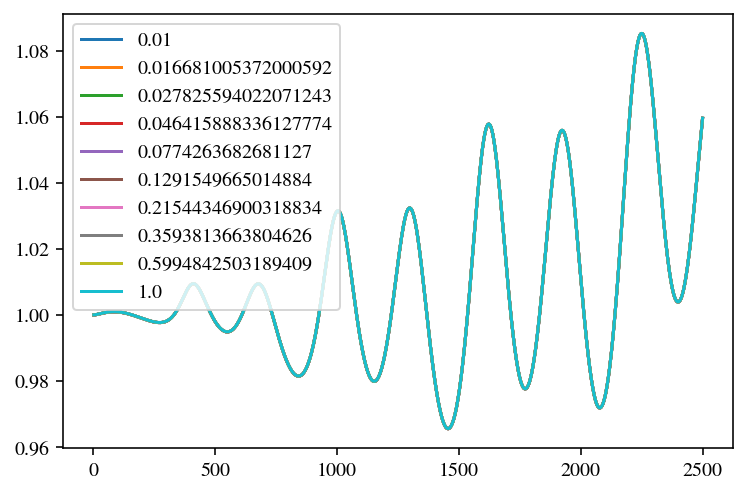

In [42]:
fig,ax = plt.subplots()

for key, val in tt_derivs.items():
    ax.plot(ll, calc.muK2*val/calc.tt_fid, label=key)

#ax.set_yscale("log")
plt.legend()
plt.show()

In [9]:
fractional_mult = np.logspace(-3, 1, 15)
print(fractional_mult)

recombination_params = {"zmax_pert": 2000,
                        "zmin_pert": 400,
                        "ll_max": 2500,
                        "thermodynamics_verbose": 0,
                        "xe_pert_type": 'none',
                        "noise_params": noise_parameters,
                        "save_output": False,
                        "ll_min_pol": 10,
                        "priors": priors,
                        }

forecasted_diagonals = []

target_params = [*bestfit.keys()]
for i,f in enumerate(fractional_mult):
    delta_param = {}
    for param in target_params:
        dp = f*planck_baseline_sigma[param]
        j=1
        while(planck_baseline_params[param]-2.*dp < 0.0):
            dp = (fractional_mult[i-j]*planck_baseline_params[param])
            j+=1
        delta_param[param]=dp
    recombination_params["delta_param"] = delta_param
    calc2 = FisherCalculator(planck_baseline_params, recombination_params, "test")
    calc2.compute_Fisher(target_params)
    forecasted_diagonals.append(np.diag(calc2.Fisher.Fisher))
np.save("forecased_diag", forecasted_diagonals)


[1.00000000e-03 1.93069773e-03 3.72759372e-03 7.19685673e-03
 1.38949549e-02 2.68269580e-02 5.17947468e-02 1.00000000e-01
 1.93069773e-01 3.72759372e-01 7.19685673e-01 1.38949549e+00
 2.68269580e+00 5.17947468e+00 1.00000000e+01]
Computing Fisher matrix for variables: ['omega_b', 'omega_cdm', 'n_s', 'tau_reio', 'ln10^{10}A_s', 'H0']
omega_b
omega_cdm
n_s
tau_reio
ln10^{10}A_s
H0
Fisher matrices calculation completed at 10/29/2022, 02:07:40
Computing Fisher matrix for variables: ['omega_b', 'omega_cdm', 'n_s', 'tau_reio', 'ln10^{10}A_s', 'H0']
omega_b
omega_cdm
n_s
tau_reio
ln10^{10}A_s
H0
Fisher matrices calculation completed at 10/29/2022, 02:08:04
Computing Fisher matrix for variables: ['omega_b', 'omega_cdm', 'n_s', 'tau_reio', 'ln10^{10}A_s', 'H0']
omega_b
omega_cdm
n_s
tau_reio
ln10^{10}A_s
H0
Fisher matrices calculation completed at 10/29/2022, 02:08:28
Computing Fisher matrix for variables: ['omega_b', 'omega_cdm', 'n_s', 'tau_reio', 'ln10^{10}A_s', 'H0']
omega_b
omega_cdm
n_s
t

In [12]:
fractional_mult = np.logspace(-3, 1, 15)

fig,axes = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(16, 15))
plt.subplots_adjust(hspace=0, wspace=0.1)

label_dict = {
    "omega_b": "\omega_b",
    "omega_cdm": "\omega_{cdm}",
    "n_s": "n_s",
    "tau_reio": "\\tau_{reio}",
    "ln10^{10}A_s": "\ln10^{10} A_s",
    "H0": "H_0"
}


#forecasted_diagonals = np.vstack(forecasted_diagonals)
forecasted_diagonals=np.load("forecased_diag.npy")

i=0
print(forecasted_diagonals[:,0])
for ax in axes.flatten():
    ax.plot(fractional_mult, forecasted_diagonals[:,i], "-+")
    #ax.set_ylabel(target_params[i])
    ax.text(0.8, 0.8, "${}$".format(label_dict[target_params[i]]), fontsize=16, transform=ax.transAxes)
    ax.axvline(0.05*planck_baseline_params[target_params[i]], color="red", linestyle="dashed")
    ax.set_xscale('log')
    i+=1

NameError: name 'bestfit' is not defined

In [11]:
priors = {"tau_reio": 0.0073}

noise_parameters = {'beam_FWHM_143_arcmin' : 7.3,
                        'beam_FWHM_217_arcmin' : 4.90,
                        #'beam_FWHM_217_arcmin' : 5.02,
                        'weight_inv_T_143' : 0.36e-4,
                        'weight_inv_P_143' : 1.61e-4,
                        'weight_inv_T_217' : 0.78e-4,
                        'weight_inv_P_217' : 3.25e-4,
                        'fsky' : 0.8,
                        'use_143' : True,
                        'use_217' : True
                        } 

recombination_params = {"zmax_pert": 2000,
                        "zmin_pert": 400,
                        "ll_max": 2500,
                        "thermodynamics_verbose": 0,
                        "xe_pert_type": 'none',
                        "noise_params": noise_parameters,
                        "save_output": False,
                        "ll_min_pol": 15,
                        #"ll_min_tt": 10,
                        "priors": priors,
                        }

bestfit_dict = sample_dict["lcdm"].getParamBestFitDict()
print(sample_dict["lcdm"].getInlineLatex("1e9_As_exp2tau", limit=1))
bestfit = {
    "omega_b": bestfit_dict["omega_b"],
    "omega_cdm": bestfit_dict["omega_cdm"],
    "n_s": bestfit_dict["n_s"],
    "tau_reio": bestfit_dict["tau_reio"],
    "ln10^{10}A_s": bestfit_dict["logA"],
    #"1e9*A_s*exp(-2tau)": 1.883,
    "H0": bestfit_dict["H0"]
}

target_params = [*bestfit.keys()]

steps = {
    "omega_b": 0.00015,
    "omega_cdm": 0.0012,
    "n_s": 0.1*0.0042,
    "tau_reio": 0.0073,
    "ln10^{10}A_s": 0.1*0.014,
    #"1e9*A_s*exp(-2tau)": 0.011, 
    "H0": 0.54
}

recombination_params["delta_param"] = steps

calc3 = FisherCalculator(bestfit, recombination_params, "test")
calc3.compute_Fisher(target_params)

#calc4 = FisherCalculator(bestfit, recombination_params, "test")
#calc4.compute_Fisher(target_params)

10^{9}A_s\exp{(-2 \tau)} = 1.881\pm 0.011
Computing Fisher matrix for variables: ['omega_b', 'omega_cdm', 'n_s', 'tau_reio', 'ln10^{10}A_s', 'H0']
omega_b
omega_cdm
n_s
tau_reio
ln10^{10}A_s
H0
Fisher matrices calculation completed at 11/02/2022, 14:42:21


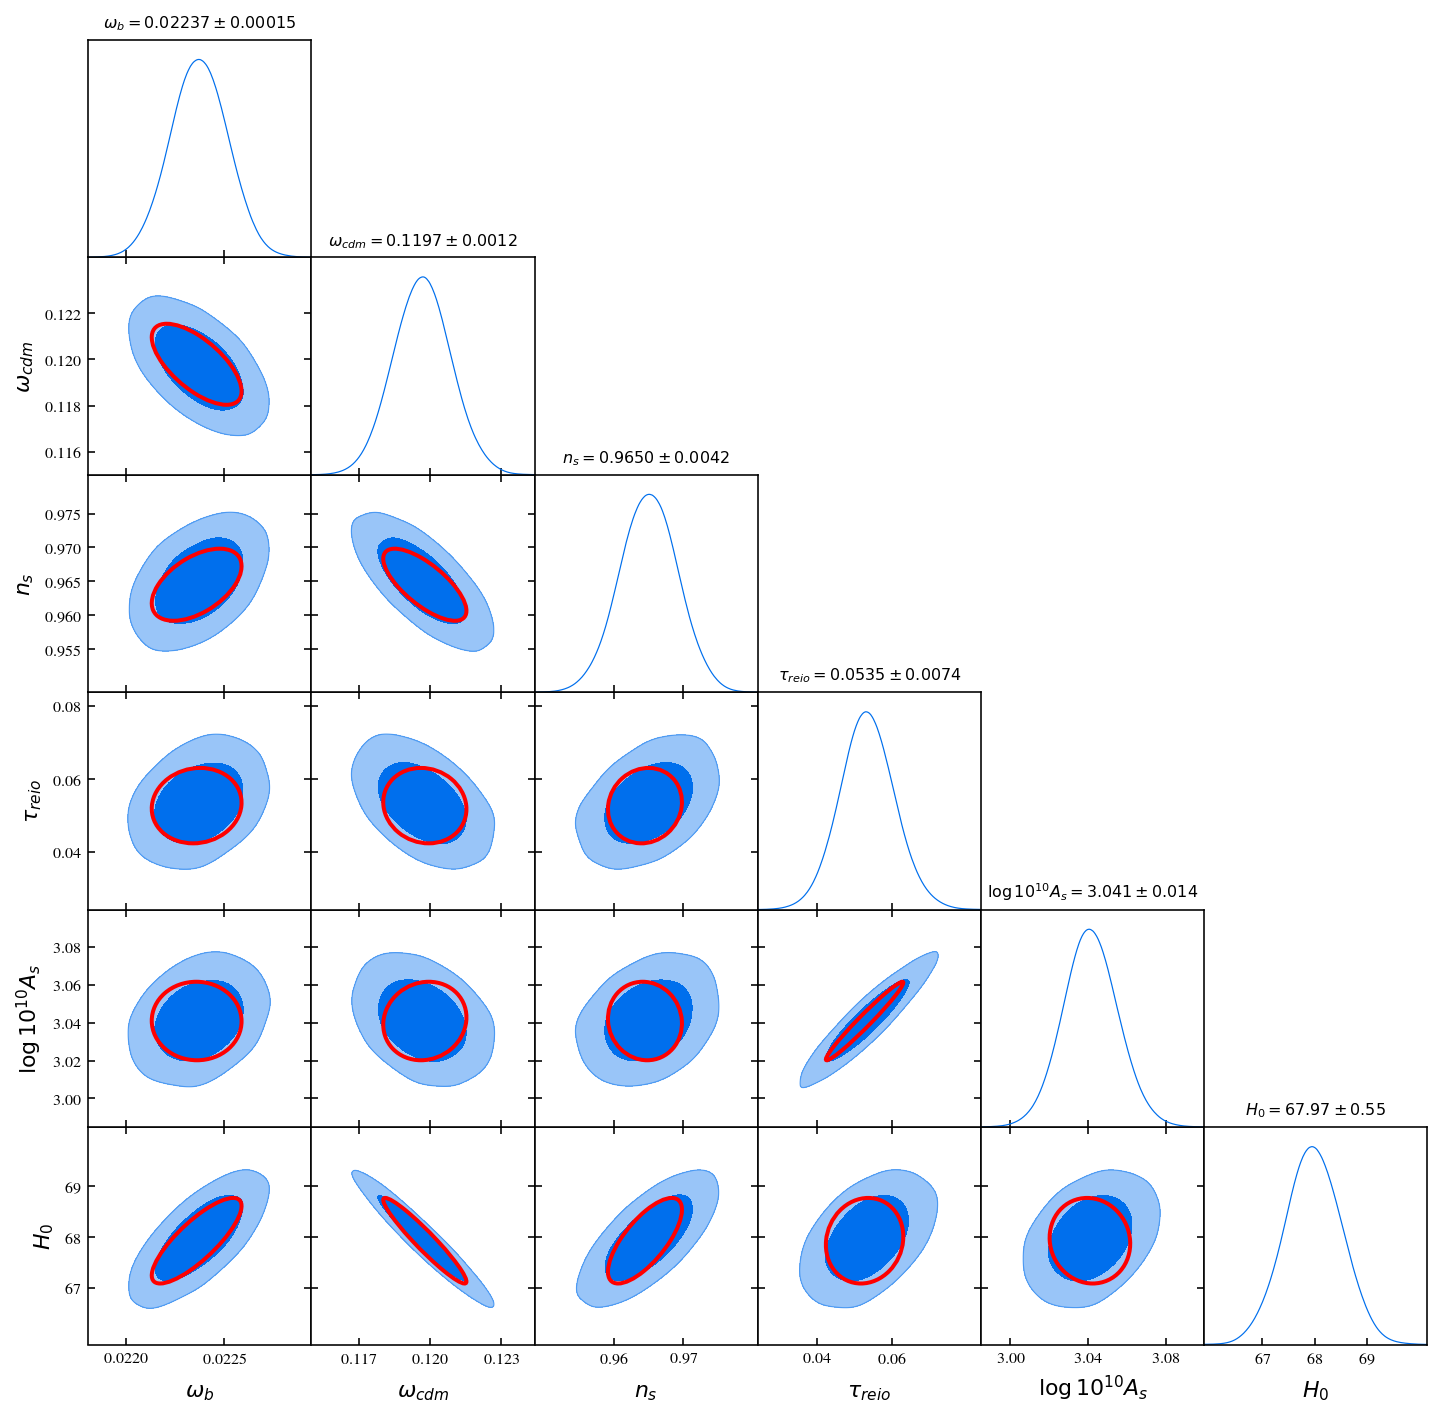

In [13]:
from getdist import plots, MCSamples, loadMCSamples
import getdist

g = plots.get_subplot_plotter()
params_to_plot = [*bestfit.keys()]
params_to_plot = ['omega_b', 'omega_cdm', 'n_s', 'tau_reio', 'logA', 'H0']
#params_to_plot = ['omega_b', 'omega_cdm', 'n_s', 'tau_reio', '1e9_As_exp2tau', 'H0']
#params_to_plot = ['omega_b', 'omega_cdm', 'n_s', 'logA', '1e9_As_exp2tau', 'H0']

param_combos = param_pairs(params_to_plot)
g.triangle_plot([sample_dict["lcdm"]], params_to_plot, filled=True, title_limit=1)
#print(g.subplots[0,0].text(0.5,0.5,"hi", transform=g.subplots[0,0].transAxes))
for c in param_combos:
    names = c.copy()
    ax = g.get_axes((c[1], c[0]))
    if(c[0]=="logA"):
        names[0]="ln10^{10}A_s"
    if(c[1]=="logA"):
        names[1]="ln10^{10}A_s"
    if(c[1]=="1e9_As_exp2tau"):
        names[1]="1e9*A_s*exp(-2tau)"
    if(c[0]=="1e9_As_exp2tau"):
        names[0]="1e9*A_s*exp(-2tau)"
    if(c[0]=="theta_s_1e2"):
        names[0]="100*theta_s"
    if(c[1]=="theta_s_1e2"):
        names[1]="100*theta_s"
    
    ax.add_patch(calc3.Fisher.ellipse2d([names[1], names[0]]))

g.export(fname="fisher_triangle_plot_lowp15_noprior_fwhm.pdf")

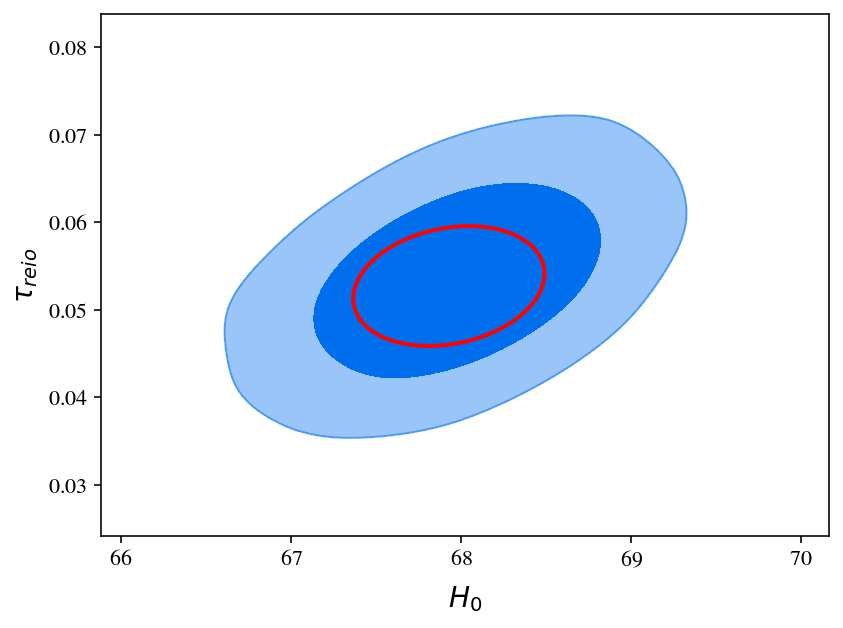

In [26]:
g = plots.get_single_plotter()
g.plot_2d([sample_dict['lcdm']], ["H0", "tau_reio"], filled=True, title_limit=1)
g.get_axes().add_patch(calc3.Fisher.ellipse2d(["H0", "tau_reio"]))
